The code imports the drive module from the google.colab package. The drive.mount function is then called with the argument '/content/drive', which specifies the path to mount the Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Libraries
This code installs the rouge package, which is a package for evaluating the quality of document summaries. It is commonly used to evaluate the performance of automatic summarization models.

The code also imports several modules that are commonly used in machine learning and natural language processing tasks. 

In [ ]:
!pip install rouge
from rouge import Rouge

import pandas as pd
import numpy as np

import csv
import re
import string

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from keras.preprocessing.text import Tokenizer

import nltk
nltk.download('stopwords') # download stopwords from nltk
from nltk.corpus import stopwords # import stopwords from nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the dataset
The code uses the pd.read_csv function from the pandas library to read in two CSV files, train.csv and test.csv, and store the resulting data in training_data and testing_data respectively. These variables will be pandas DataFrame objects containing the data from the CSV files.


In [ ]:
#Read the training data from a CSV file and save it in a pandas dataframe
training_data = pd.read_csv('/content/drive/MyDrive/Final NLP/train.csv')
# Read the test data from a CSV file and save it in a pandas dataframe
testing_data = pd.read_csv('/content/drive/MyDrive/Final NLP/test.csv')

## Preprocessing the Data
The code is dropping the id column from the training_data and testing_data dataframes, and resetting the indices of the remaining rows.

The drop function is used to drop the id column from the dataframes. The axis parameter is set to 1, which specifies that we want to drop a column, not a row.

The reset_index function is then called on the resulting dataframes to reset the indices of the rows. The drop parameter is set to True, which specifies that the old index values should be dropped and replaced with the new, reset indices.

Removing the id column and resetting the indices can make it easier to work with the data and feed it into a model.

In [ ]:
# Remove the 'id' column from the train and test data
training_data = training_data.drop(['id'], axis=1)

# Reset the index of the train data
training_data = training_data.reset_index(drop=True)

# Remove the 'id' column from the test data
testing_data = testing_data.drop(['id'], axis=1)

# Reset the index of the test data
testing_data = testing_data.reset_index(drop=True)


The code creates a dictionary that maps common English contractions to their expanded forms. 

For example, the contraction "ain't" is mapped to the expanded form "am not". This dictionary can be used to expand contractions in document. 

For instance, if a sentence contains the contraction "ain't", it can be replaced with "am not" using this dictionary. This can be useful for improving the readability and grammar of document.

In [ ]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

This code defines a function called text_cleaner that takes a string of document as input and performs a series of operations on it to clean and pre-process the document. The function has an optional boolean parameter remove_stopwords, which determines whether or not to remove stop words (common words such as "the" and "and" that do not provide significant meaning) from the document.

The document is first converted to lowercase and split into a list of words. A loop is then used to go through each word in the document and check if it is a word that is found in a dictionary of contractions. If the word is in the contractions dictionary, the corresponding expanded form of the word is added to a temporary list. Otherwise, the word itself is added to the list. The temporary list is then joined together with spaces to form a new string of pre-processed document.

The pre-processed document is then processed further using regular expressions (regex) to remove certain characters and patterns. URLs are removed, as well as HTML tags and entities such as &amp;. Various punctuation marks and symbols are also removed, as well as the string '<br />' and the apostrophe character ''.

If the remove_stopwords parameter is set to True, the document is split into a list of words again, and a list comprehension is used to remove stop words from the document. The list of words is then joined together again with spaces to form the final pre-processed document.

The cleaned document is returned by the function. 

In [ ]:
def text_cleaner(document, remove_stopwords=True):
  # convert document to lowercase
  document = document.lower()
  # split document into a list of words
  document = document.split()

  # create a list to hold the cleaned words
  temporary = []

  # check each word in the list
  for word in document:
      # if the word is in the contractions dictionary, replace it with the value from the dictionary
      if word in contractions:
          temporary.append(contractions[word])
      # otherwise, just add the word to the list as is
      else:
          temporary.append(word)

  # join the cleaned words back into a string
  document = ' '.join(temporary)

  # remove URLs from the document
  document = re.sub(r'https?:\/\/.*[\r\n]*', '', document, flags=re.MULTILINE)

  # remove HTML 'a href' links from the document
  document = re.sub(r'\<a href', ' ', document)

  # remove the '&amp;' entity from the document
  document = re.sub(r'&amp;', '', document) 

  # remove punctuation and special characters from the document
  document = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', document)

  # remove the '<br />' HTML tag from the document
  document = re.sub(r'<br />', ' ', document)

  # remove single quotes from the document
  document = re.sub(r'\'', ' ', document)

  # if the remove_stopwords parameter is True, remove stop words from the document
  if remove_stopwords:
      # split the document into a list of words
      document = document.split()
      
      # get a set of stop words in English
      stops = set(stopwords.words('english'))
      
      # remove stop words from the list of words
      document = [w for w in document if w not in stops]
      
      # join the cleaned words back into a string
      document = ' '.join(document)
      
  # return the cleaned document
  return document


This code is importing the NLTK library and downloading the stopwords package. It then imports the stopwords corpus from NLTK. It creates two empty lists to store cleaned summaries and texts, respectively. Then, it loops through the summaries and texts in the training_data dataframe, cleans the document with a function called "text_cleaner," and appends the cleaned document to the appropriate list. After cleaning all of the summaries and texts, it prints a message indicating that the cleaning is complete and then deletes the training_data variable to free up memory.

In [ ]:
preprocessed_summaries  = [] # initialize empty list to store cleaned summaries
for summary in training_data.highlights: # loop through each summary in the train data highlights column
  preprocessed_summaries .append(text_cleaner(summary, remove_stopwords=False)) # clean the summary and append to list, with stopwords not removed
print('Cleaning Summaries Complete')

clean_documents = [] # initialize empty list to store cleaned texts
for document in training_data.article: # loop through each document in the train data article column
  clean_documents.append(text_cleaner(document)) # clean the document and append to list
print('Cleaning Texts Complete')
del training_data # delete the training_data variable to free up memory

Cleaning Summaries Complete
Cleaning Texts Complete


In [ ]:
# create an empty dataframe called New_df
New_df= pd.DataFrame()

# add the first 110000 elements of the clean_documents list as a column called 'document' to New_df
New_df['document'] = clean_documents[:110000]

# add the first 110000 elements of the preprocessed_summaries  list as a column called 'summary' to New_df
New_df['summary'] = preprocessed_summaries [:110000]

# replace empty values in the 'summary' column with NaN
New_df['summary'].replace('', np.nan, inplace=True)

# drop all rows with NaN values in any column
New_df.dropna(axis=0, inplace=True)

# apply a lambda function to each value in the 'summary' column, adding special start and end tokens to the string
New_df['summary'] = New_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')

# delete the clean_documents and preprocessed_summaries  variables
del clean_documents
del preprocessed_summaries 

## Tokenizing Text and the Summary Data
The code splits the clean dataframe into four variables: train_x, test_x, train_y, and test_y. train_x and train_y will be used to train a machine learning model, and test_x and test_y will be used to evaluate the performance of the model. The test_size parameter specifies the proportion of the data that should be used for testing, and random_state is a seed value for the random number generator, which ensures that the same split will be generated each time the code is run. Finally, the New_dfdataframe is deleted.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(New_df['document'], New_df['summary'], # split the data into training and testing sets
                                                    test_size=0.1, # use 10% of the data for testing
                                                    random_state=0) # use a fixed seed for the random number generator
del New_df# delete the original dataframe


This code creates a tokenizer object that is fit on a list of texts. It then iterates through the words and their counts in the tokenizer's dictionary, incrementing a few counters based on whether the word's count is less than a specified threshold. At the end, the code will have counted the total number of words, the total frequency of all words, the number of words with a count less than the threshold, and the total frequency of words with a count less than the threshold.






In [ ]:
# Initialize the Tokenizer object
xTokenizer = Tokenizer()

# Fit the Tokenizer object on the training data
xTokenizer.fit_on_texts(list(train_x))

# Set the threshold for frequency count to 4
threshold = 4

# Initialize counters for low frequency words and total word count
count = 0
total_count = 0
frequency = 0
total_frequency = 0

# Iterate over the word_counts dictionary to calculate the total word count, total frequency, and count/frequency of words with frequency less than the threshold
for key, value in xTokenizer.word_counts.items():
  # Increment total word count
  total_count += 1
  # Increment total frequency count
  total_frequency += value
  # Check if the current word has a frequency less than the threshold
  if value < threshold:
    # Increment low frequency word count
    count += 1
    # Increment low frequency word frequency count
    frequency += value

The code calculates the percentage of rare words in the vocabulary, the total coverage of rare words, and the total number of words in the document vocabulary.

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0) # Calculate the percentage of rare words in the vocabulary
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0) # Calculate the total coverage of rare words in the document
t_max_features = total_count - count # Calculate the total number of words in the document vocabulary
print('Text Vocab: ', t_max_features) # Print the document vocabulary size.

% of rare words in vocabulary:  60.00719413677853
Total Coverage of rare words:  0.7458147584629847
Text Vocab:  133418


The code creates a tokenizer and fits it on a list of train labels. It then sets a threshold and initializes some counters for word count and frequency. It iterates through the word counts of the tokenizer and increments the counters for total count and total frequency, as well as the count and frequency of words that have a frequency less than the threshold.

In [ ]:
# initialize Tokenizer object and fit on training labels
yTokenizer = Tokenizer()
yTokenizer.fit_on_texts(list(train_y))

# threshold for minimum frequency of words
threshold = 6

# counters for number and frequency of words below threshold
count = 0
total_count = 0
frequency = 0
total_frequency = 0

# loop through word counts and update counters
for key, value in yTokenizer.word_counts.items():
  total_count += 1 # increment total number of words
  total_frequency += value # increment total frequency of words
  if value < threshold: # check if word frequency is below threshold
    count += 1 # increment number of words below threshold
    frequency += value # increment frequency of words below threshold

The code calculates the percentage of rare words in the vocabulary and the total coverage of rare words in the vocabulary. It then prints the summary of the vocab with the number of rare words removed.

In [ ]:
# print the percentage of rare words in the vocabulary
print('% of rare words in vocabulary: ', (count/total_count)*100.0)

# print the total coverage of rare words
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)

# calculate the summary vocabulary size by subtracting the count of rare words from the total number of words
s_max_features = total_count-count

# print the summary vocabulary size
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  70.11489659306625
Total Coverage of rare words:  2.4837378859339996
Summary Vocab:  29912


In [ ]:
maxlen_text = 800 # maximum length of document
maxlen_summ = 150 # maximum length of summary

The code sets up a tokenizer, fits it on the training data, and applies it to the training and validation data. It then pads the resulting sequences to a specified length.

In [ ]:
val_x = test_x # assign test_x to val_x

# initialize tokenizer with max number of features
xTokenizer = Tokenizer(num_words=t_max_features)

# fit tokenizer on train_x
xTokenizer.fit_on_texts(list(train_x))

# convert train_x and val_x to sequences
train_x = xTokenizer.texts_to_sequences(train_x)
val_x = xTokenizer.texts_to_sequences(val_x)

# pad sequences to the same length
train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [ ]:
val_y = test_y # assign test_y to val_y

# initialize tokenizer with max number of features
yTokenizer = Tokenizer(num_words=s_max_features)

# fit tokenizer on train_y
yTokenizer.fit_on_texts(list(train_y))

# convert train_y and val_y to sequences
train_y = yTokenizer.texts_to_sequences(train_y)
val_y = yTokenizer.texts_to_sequences(val_y)

# pad sequences to the same length
train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [ ]:
# print the shape of the training sequence
print("Training Sequence", train_x.shape)

# print the shape of the target values
print('Target Values Shape', train_y.shape)

# print the shape of the test sequence
print('Test Sequence', val_x.shape)

# print the shape of the target test
print('Target Test Shape', val_y.shape)

Training Sequence (99000, 800)
Target Values Shape (99000, 150)
Test Sequence (11000, 800)
Target Test Shape (11000, 150)


## Loading the pretrained Glove embedding
The code opens a document file containing word embeddings and creates a dictionary with the words as keys and their corresponding embedding vectors as values. The dimensionality of the vectors is set to 100.

In [ ]:
# create an empty dictionary
embeding_index = {}

# set the dimension of the word embeddings
embed_dim = 100

# open the file containing the word embeddings
with open('/content/drive/MyDrive/Final NLP/glove.6B.100d.txt') as f:

  # iterate over each line in the file
  for line in f:
      
      # split the line by whitespace to get the word and its corresponding values
      values = line.split()
      
      # the first value is the word
      word = values[0]
      
      # the rest of the values are the coefficients for the word's embedding
      coefs = np.asarray(values[1:], dtype='float32')
      
      # add the word and its embedding to the dictionary
      embeding_index[word] = coefs

The code creates a matrix of zeros with dimensions t_max_features by embed_dim. For each word and its corresponding index in the xTokenizer, it checks if the index is less than t_max_features and if the word has a corresponding vector in the embedding_index. If both conditions are met, it assigns the vector to the corresponding index in the t_embed matrix.

In [ ]:
t_embed = np.zeros((t_max_features, embed_dim)) # create a zero matrix of size t_max_features x embed_dim
for word, i in xTokenizer.word_index.items(): # for each word and its index in the xTokenizer
  vec = embeding_index.get(word) # get the vector for the word from the embedding index
  if i < t_max_features and vec is not None: # if the index is less than the max features and the vector is not None
    t_embed[i] = vec # set the vector value in the t_embed matrix at the index position

In [ ]:
s_embed = np.zeros((s_max_features, embed_dim)) # create a zero matrix of size t_max_features x embed_dim
for word, i in yTokenizer.word_index.items(): # for each word and its index in the xTokenizer
  # Get the embedding vector for the current word
  vec = embeding_index.get(word) # get the vector for the word from the embedding index
  if i < s_max_features and vec is not None: # if the index is less than the max features and the vector is not None
    s_embed[i] = vec # set the vector value in the t_embed matrix at the index position

In [ ]:
del embeding_index

## Defining the Model Architecture
The code creates a seq2seq model with an encoder and decoder. The encoder uses a bidirectional LSTM layer and the decoder uses a LSTM layer with dropout and recurrent dropout. The model is then summarized and plotted.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 100)     13341800    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 256),        234496      ['embedding[0][0]']              
                                 (None, 128),                                                 

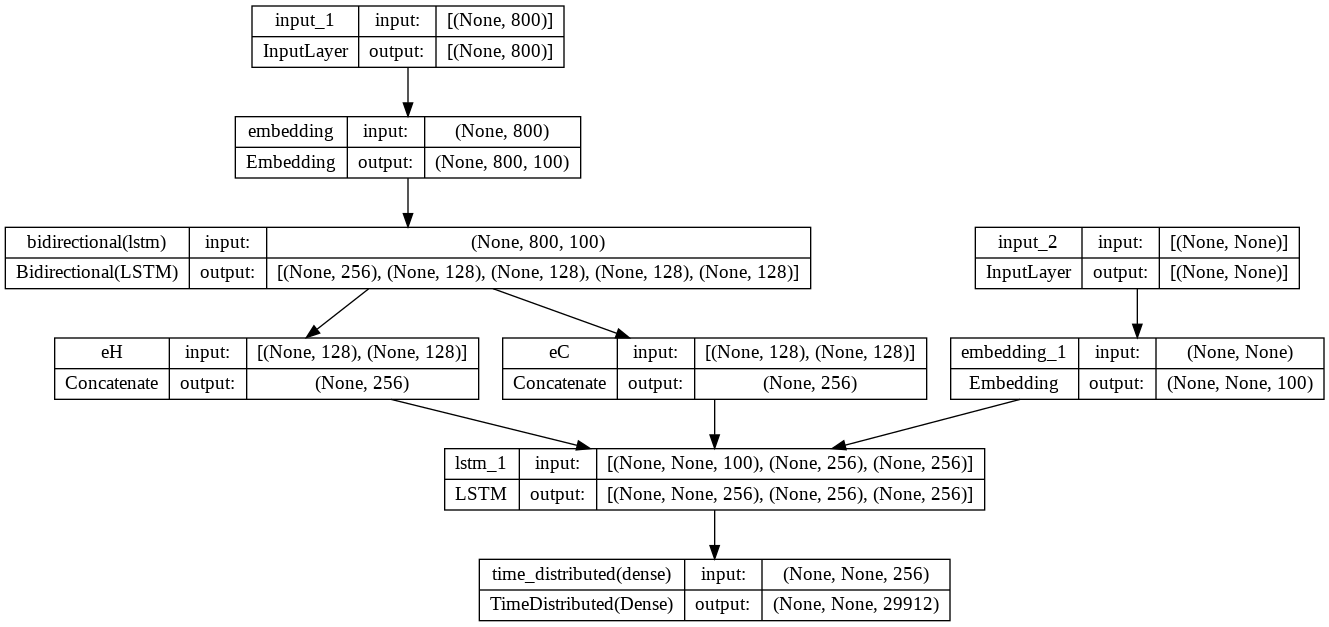

In [ ]:
latent_dim = 128 # number of dimensions in the latent space

# Encoder
eInput  = Input(shape=(maxlen_text, )) # input layer for the encoder
eEmbed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(eInput ) # embedding layer for the encoder

eLstm = Bidirectional(LSTM(latent_dim, return_state=True)) # bidirectional LSTM for the encoder
eOut, eFh, eFc, eBh, eBc = eLstm(eEmbed) # forward hidden state, forward cell state, backward hidden state, and backward cell state
eH= Concatenate(axis=-1, name='eH')([eFh, eBh]) # concatenate forward and backward hidden states
eC= Concatenate(axis=-1, name='eC')([eFc, eBc]) # concatenate forward and backward cell states

#Decoder
dInput = Input(shape=(None, )) # input layer for the decoder
dEmbed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dInput) # embedding layer for the decoder
dLstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2) # LSTM layer for the decoder
dOut, _, _ = dLstm(dEmbed, initial_state=[eH, eC]) # output sequence and hidden and cell states

dDense = TimeDistributed(Dense(s_max_features, activation='softmax')) # time distributed dense layer for the decoder
dOut = dDense(dOut) # output of the decoder

model = Model([eInput , dInput], dOut) # define the model with encoder and decoder inputs and decoder output
model.summary() # print model summary

plot_model(
model,
to_file='./seq2seq.png',
show_shapes=True,
show_layer_names=True,
rankdir='TB',
expand_nested=False,
dpi=96) # plot the model diagram

## DO NOT RUN
The code compiles a model with a loss function of sparse categorical crossentropy and an optimizer of rmsprop. It then sets up an early stopping callback with a monitor for the validation loss, a mode of 'min', and a patience of 2. The model is then trained for 10 epochs with a batch size of 128, using the early stopping callback and the specified validation data.

In [ ]:
# model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop') # compile the model with sparse categorical crossentropy loss and rmsprop optimizer
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2) # define early stopping callback with minimum validation loss as monitor and a patience of 2 epochs
# model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=10, callbacks=[early_stop], batch_size=128, verbose=2, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:])) # fit the model on the training data with early stopping callback and validation data, using 10 epochs and a batch size of 128, with verbose output set to 2

In [ ]:
## Save the model
# model.save('model.h5')

## Load the saved Model

In [ ]:
from keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/Final NLP/model.h5')

## Drawing Inference
The code is defining two models, an encoder model and a decoder model, for a neural network. The encoder model takes in a sequence of input data and outputs the hidden state and cell state of a long short-term memory (LSTM) layer. The decoder model takes in a sequence of input data, initial hidden and cell states, and outputs the final output of the LSTM layer and the hidden and cell states. These models will be used in a sequence-to-sequence model for tasks such as machine translation.

In [ ]:
eModel = Model(inputs=eInput , outputs=[eH, eC]) # define encoder model with input and output

dInitH= Input(shape=(latent_dim*2, )) # define initial state for hidden layer of decoder
dInitC = Input(shape=(latent_dim*2, )) # define initial state for cell layer of decoder

dOut, dH, dC = dLstm(dEmbed, initial_state=[dInitH, dInitC]) # pass the initial state to decoder LSTM
dFinal = dDense(dOut) # apply dense layer to decoder output

dModel = Model([dInput]+[dInitH, dInitC], [dFinal]+[dH, dC]) # define decoder model with input and output states

The code is a function that generates a summary of a given input sequence. It first predicts the hidden and cell states of the input sequence using an encoder model. Then, it initializes the next token to be the start-of-sequence token and sets up an empty output sequence string.

The function then enters a loop that will continue until the stop condition is met, which is when the end-of-sequence token is encountered or the maximum number of iterations is reached. In each iteration, the decoder model is used to predict the next token and the hidden and cell states of the sequence. The token with the highest probability is selected and added to the output sequence if it is not a start-of-sequence or end-of-sequence token. The next token is then updated to be the selected token and the loop continues.

Finally, the function returns the generated output sequence as the summary.

In [ ]:
def generate_summary(input_seq):
  h, c = eModel.predict(input_seq) # get hidden and cell state from encoder model

  next_token = np.zeros((1, 1))
  next_token[0, 0] = yTokenizer.word_index['sostok']  # set next token to start of sequence token
  output_seq = ''

  stop = False
  count = 0

  while not stop:
      if count > 100:  # maximum number of iterations
          break
      decoder_out, state_h, state_c = dModel.predict([next_token]+[h, c])  # get output from decoder model
      token_idx = np.argmax(decoder_out[0, -1, :])  # get index of predicted token
      
      if token_idx == yTokenizer.word_index['eostok']:  # end of sequence token
          stop = True
      elif token_idx > 0 and token_idx != yTokenizer.word_index['sostok']:  # exclude special tokens
          token = yTokenizer.index_word[token_idx]  # get actual word from token index
          output_seq = output_seq + ' ' + token  # append to output sequence
      
      next_token = np.zeros((1, 1))
      next_token[0, 0] = token_idx  # set next token to predicted token
      h, c = state_h, state_c  # update hidden and cell state
      count += 1
      
  return output_seq  # return generated summary sequence

This code is preprocessing a list of sentences in the "testing_data" variable. First, the "text_cleaner" function is applied to each sentence in the "testing_data.article" list to clean the document. Then, the "texts_to_sequences" function from the "xTokenizer" object is applied to the cleaned document to convert the document into a sequence of numerical tokens. Finally, the "pad_sequences" function is used to pad the sequences with zeros at the end to ensure that all sequences are of the same length as specified by the "maxlen_text" variable. This is done to prepare the document for input into a machine learning model.

In [ ]:
#iterate through each sentence in testing_data.article
test_inputs = [text_cleaner(sent) for sent in testing_data.article]

#convert the cleaned document to sequences of integers
test_inputs = xTokenizer.texts_to_sequences(list(test_inputs))

#pad the sequences to match the maximum length of document
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

## DO NOT RUN

In [ ]:
# hyps = []
# # Open the file 'result.csv' in write mode
# with open('./result.csv', 'w') as f:
# # Create a CSV writer object
#   writer = csv.writer(f)
#   # Write the header row to the file
#   writer.writerow(['Article', 'Original Summary', 'Model Output'])
#   # Loop through the first 100 test inputs
#   for i in range(100):
#     # Generate a summary for the current test input
#     our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
#     # Add the summary to the list of hypotheses
#     hyps.append(our_summ)
#     # Write a row to the file with the article, original summary, and generated summary
#     writer.writerow([testing_data.article[i], testing_data.highlights[i], our_summ])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step


#Conclusion 
The code creates an instance of the Rouge class and then calls the get_scores method on that instance. The method takes three arguments: hyps, testing_data.highlights, and avg=True, ignore_empty=True.

The hyps argument is a list of hypotheses (i.e., predicted summaries) to be evaluated.

The testing_data.highlights argument is a list of references (i.e., true summaries) against which the hypotheses will be compared.

The avg=True argument specifies that the method should return the average score across all the hypotheses and references.

The ignore_empty=True argument specifies that the method should ignore empty hypotheses and references when calculating the average score.

In [ ]:
rouge = Rouge()
rouge.get_scores(hyps, testing_data.highlights, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.002669079258319496,
  'p': 0.0012612716784702776,
  'f': 0.001678424569793078},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.002669079258319496,
  'p': 0.0012612716784702776,
  'f': 0.001678424569793078}}

In [ ]:
#get summary for one custom input
def get_summary(input_text):
    #clean the input document
    input_text = text_cleaner(input_text)
    #convert the cleaned document to sequences of integers
    input_text = xTokenizer.texts_to_sequences([input_text])
    #pad the sequences to match the maximum length of document
    input_text = pad_sequences(input_text, maxlen=maxlen_text, padding='post')
    #generate the summary
    summary = generate_summary(input_text)
    return summary


In [ ]:
# Define the input text
text = """Dougie Freedman is on the verge of agreeing a new two-year deal to remain at Nottingham Forest. Freedman has stabilised Forest since he replaced cult hero Stuart Pearce and the club's owners are pleased with the job he has done at the City Ground. Dougie Freedman is set to sign a new deal at Nottingham Forest . Freedman has impressed at the City Ground since replacing Stuart Pearce in February . They made an audacious attempt on the play-off places when Freedman replaced Pearce but have tailed off in recent weeks. That has not prevented Forest's ownership making moves to secure Freedman on a contract for the next two seasons."""

In [ ]:
summary=get_summary(text)

1/1 [==============================] - 0s 18ms/step


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
#calculate bleu score for one sentence pair
reference = text.split()
candidate = summary.split()
#calculate the bleu score
score = sentence_bleu([reference], candidate)
print(score)


['Dougie', 'Freedman', 'is', 'on', 'the', 'verge', 'of', 'agreeing', 'a', 'new', 'two-year', 'deal', 'to', 'remain', 'at', 'Nottingham', 'Forest.', 'Freedman', 'has', 'stabilised', 'Forest', 'since', 'he', 'replaced', 'cult', 'hero', 'Stuart', 'Pearce', 'and', 'the', "club's", 'owners', 'are', 'pleased', 'with', 'the', 'job', 'he', 'has', 'done', 'at', 'the', 'City', 'Ground.', 'Dougie', 'Freedman', 'is', 'set', 'to', 'sign', 'a', 'new', 'deal', 'at', 'Nottingham', 'Forest', '.', 'Freedman', 'has', 'impressed', 'at', 'the', 'City', 'Ground', 'since', 'replacing', 'Stuart', 'Pearce', 'in', 'February', '.', 'They', 'made', 'an', 'audacious', 'attempt', 'on', 'the', 'play-off', 'places', 'when', 'Freedman', 'replaced', 'Pearce', 'but', 'have', 'tailed', 'off', 'in', 'recent', 'weeks.', 'That', 'has', 'not', 'prevented', "Forest's", 'ownership', 'making', 'moves', 'to', 'secure', 'Freedman', 'on', 'a', 'contract', 'for', 'the', 'next', 'two', 'seasons.']
['cooked', 'rewarded', 'anarchists'